In [1]:
import batoid
import numpy as np
from IPython.display import display
from ipywidgets import interact, interactive_output, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
telescope = batoid.Optic.fromYaml("LSST_r.yaml")

In [3]:
np.random.seed(123)
rays = batoid.RayVector.asPolar(
    optic=telescope, wavelength=625e-9,
    theta_x=np.deg2rad(1.5), theta_y=0.0,
    nrandom=1000
)

In [4]:
outRays = telescope.trace(rays.copy())
np.sum(~outRays.vignetted), len(outRays)

(954, 1000)

In [5]:
def randomRaySumXYZ(outRays, nray, xsize=5*10e-6, ysize=5*10e-6, zsize=5*10e-6, nx=100, plotk=False, alpha=0.1):
    w = np.nonzero(~outRays.vignetted)[0]
    xmean = np.mean(outRays.x[w])
    ymean = np.mean(outRays.y[w])
    zmean = np.mean(outRays.z[w])
    tmean = np.mean(outRays.t[w])

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for ax in axes.ravel():
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='both', which='minor', labelsize=18)
    
    # XY plots first
    xrange = xmean + xsize*np.array([-0.5, 0.5])
    yrange = ymean + ysize*np.array([-0.5, 0.5])

    xs = np.linspace(xrange[0], xrange[1], nx)
    ys = np.linspace(yrange[0], yrange[1], nx)
    xs, ys = np.meshgrid(xs, ys)
    zs = np.ones_like(xs)*zmean
    
    points = np.concatenate([aux[..., None] for aux in (xs, ys, zs)], axis=-1)
    rng = np.random.default_rng(123)
    indices = rng.choice(w, nray)
    tmpRays = outRays[indices]
    
    amplitudes = np.empty_like(xs, dtype=np.complex128)
    for idx in np.ndindex(amplitudes.shape):
        amplitudes[idx] = tmpRays.sumAmplitude(points[idx], tmean)
    
    extent = np.array([-xsize, xsize, -ysize, ysize])/10e-6
    i0 = axes[0,0].imshow(np.real(amplitudes), extent=extent)
    axes[0,0].set_title(r"$Re[E]$", fontsize=18)
    axes[0,0].set_xlabel("X", fontsize=18)
    axes[0,0].set_ylabel("Y", fontsize=18)

    i1 = axes[0,1].imshow(np.abs(amplitudes)**2, extent=extent)
    axes[0,1].set_title(r"$|E|^2$", fontsize=18)
    axes[0,1].set_xlabel("X", fontsize=18)
    axes[0,1].set_ylabel("Y", fontsize=18)

    if plotk:
        for ray in tmpRays:
            axes[0,0].plot(
                (np.array([0, ray.vx])*10e-6 + ray.x - xmean)/10e-6,
                (np.array([0, ray.vy])*10e-6 + ray.y - ymean)/10e-6,
                c='r', alpha=alpha
            )            

    # Now XZ plots    
    xrange = xmean+xsize*np.array([-0.5, 0.5])
    zrange = zmean+zsize*np.array([-0.5, 0.5])

    xs = np.linspace(xrange[0], xrange[1], nx)
    zs = np.linspace(zrange[0], zrange[1], nx)
    xs, zs = np.meshgrid(xs, zs)
    ys = np.ones_like(xs)*ymean
    
    points = np.concatenate([aux[..., None] for aux in (xs, ys, zs)], axis=-1)

    amplitudes = np.empty_like(xs, dtype=np.complex128)
    for idx in np.ndindex(amplitudes.shape):
        amplitudes[idx] = tmpRays.sumAmplitude(points[idx], tmean)
    
    extent = np.array([-xsize, xsize, -zsize, zsize])/10e-6
    
    i0 = axes[1,0].imshow(np.real(amplitudes), extent=extent)
    axes[1,0].set_title(r"$Re[E]$", fontsize=18)
    axes[1,0].axhline(0, c='w', lw=4)
    axes[1,0].set_xlabel("X", fontsize=18)
    axes[1,0].set_ylabel("Z", fontsize=18)
    
    i1 = axes[1,1].imshow(np.abs(amplitudes)**2, extent=extent)
    axes[1,1].set_title(r"$|E|^2$", fontsize=18)
    axes[1,1].axhline(0, c='w', lw=4)
    axes[1,1].set_xlabel("X", fontsize=18)
    axes[1,1].set_ylabel("Z", fontsize=18)

    if plotk:
        for ray in tmpRays:
            axes[1,0].plot(
                (np.array([0, ray.vx])*10e-6 + ray.x - xmean)/10e-6,
                (np.array([0, ray.vz])*10e-6 + ray.z - zmean)/10e-6,
                c='r', alpha=alpha
            )            
    plt.tight_layout()

/tmp/ipykernel_247442/984609311.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (np.array([0, ray.vx])*10e-6 + ray.x - xmean)/10e-6,
/tmp/ipykernel_247442/984609311.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (np.array([0, ray.vy])*10e-6 + ray.y - ymean)/10e-6,
/tmp/ipykernel_247442/984609311.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' wh

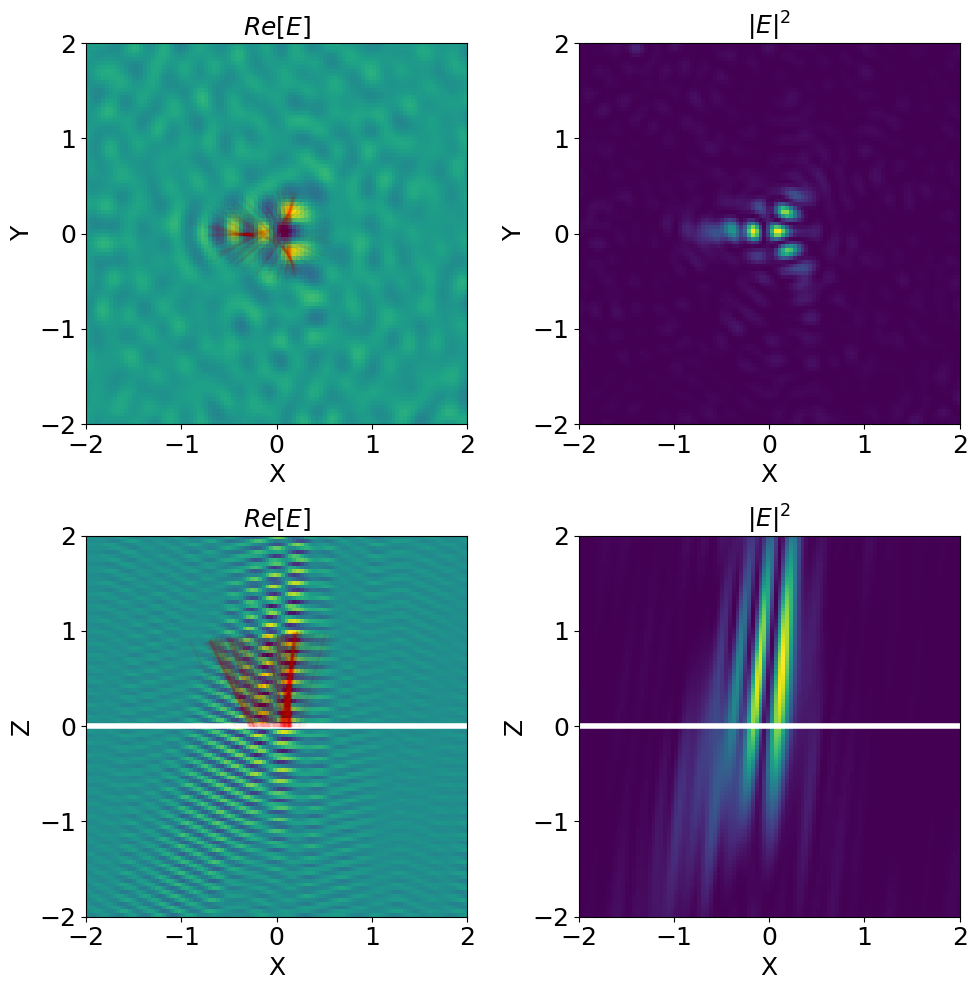

In [6]:
randomRaySumXYZ(outRays, len(outRays), xsize=2*10e-6, ysize=2*10e-6, zsize=2*10e-6, plotk=True, alpha=0.01)